In [1]:
import numpy as np
from os.path import join, dirname, basename
import rasterio as rio
import sys
sys.path.append('/Users/zachkeskinen/Documents/uavsar_snow/functions')
from tiff_convert import read_annotation
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr
from glob import glob
import shutil

ModuleNotFoundError: No module named 'tiff_convert'

In [2]:
in_fp = '/Users/zachkeskinen/Documents/uavsar_snow/jemez_slc/alamos_35915_01_BU_s1_2x8.llh'
in_2_fp = '/Users/zachkeskinen/Documents/uavsar_snow/jemez_slc/alamos_35915_01_BU_s1_2x8.lkv'
ann_fp = '/Users/zachkeskinen/Documents/uavsar_snow/jemez_slc/alamos_35915_20005_003_200212_L090HH_01_BU.ann'

in_dir = dirname(in_fp)
out_dir = dirname(in_fp)
tmp_dir = join(out_dir,'tmp')
os.makedirs(tmp_dir, exist_ok=True)

In [3]:
desc = read_annotation(ann_fp)

In [4]:
nrows = desc['lkv_1_2x8.set_rows']['value']
ncols = desc['lkv_1_2x8.set_cols']['value']
dt = np.dtype('<f')

arr = np.fromfile(in_fp, dtype = dt)
res = {}
res['llh.lats'] = arr[::3].reshape(nrows, ncols)
res['llh.longs'] = arr[1::3].reshape(nrows, ncols)
res['llh.elev'] = arr[2::3].reshape(nrows, ncols)

arr = np.fromfile(in_2_fp, dtype = dt)
res['lkv.east'] = arr[::3].reshape(nrows, ncols)
res['lkv.north'] = arr[1::3].reshape(nrows, ncols)
res['lkv.up'] = arr[2::3].reshape(nrows, ncols)

In [5]:
profile = {
        'driver': 'GTiff',
        'interleave': 'band',
        'tiled': False,
        'nodata': 0,
        'width': ncols,
        'height':nrows,
        'count':1,
        'dtype':'float32'
    }

for name, arr in res.items():
    with rio.open(join(tmp_dir, name + '.tif'), 'w', **profile) as dst:
        dst.write(arr.astype(arr.dtype), 1)

/Users/zachkeskinen/miniconda3/envs/gdal/lib/python3.7/site-packages/rasterio/__init__.py:236: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  **kwargs)


In [6]:
data_to_process = glob(join(tmp_dir, '*.tif')) # list all .llh files
for data_path in data_to_process: # loop to open and translate .llh to .vrt, and save .vrt using gdal
    raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly) # read in rasters
    raster = gdal.Translate(join(tmp_dir, basename(data_path).replace('.tif','.vrt')), raster_dataset, format = 'VRT', outputType = gdal.GDT_Float32)
    raster_dataset = None

In [7]:
# function courtesy of Dr. Gareth Funning, UC Riverside, UNAVCO InSAR Short Course

def geocodeUsingGdalWarp(infile, latfile, lonfile, outfile,
                         insrs=4326, outsrs=None,
                         spacing=None, fmt='GTiff', bounds=None,
                         method='near'):
    '''
    Geocode a swath file using corresponding lat, lon files
    '''
    sourcexmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    driver = gdal.GetDriverByName('VRT')
    tempvrtname = join(tmp_dir, 'temp_ele.vrt')
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    
    tempds = driver.Create(tempvrtname, inds.RasterXSize, inds.RasterYSize, 0)
    
    for ii in range(inds.RasterCount):
        band = inds.GetRasterBand(1)
        tempds.AddBand(band.DataType)
        tempds.GetRasterBand(ii+1).SetMetadata({'source_0': sourcexmltmpl.format(infile, ii+1)}, 'vrt_sources')
  
    sref = osr.SpatialReference()
    sref.ImportFromEPSG(insrs)
    srswkt = sref.ExportToWkt()
    tempds.SetMetadata({'SRS' : srswkt,
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 
                        'GEOLOCATION')
    
    band = None
    tempds = None 
    inds = None
    
    if spacing is None:
        spacing = [None, None]
    warpOptions = gdal.WarpOptions(format=fmt,
                                   xRes=spacing[0], yRes=spacing[0],
                                   dstSRS=outsrs, outputBounds = bounds, 
                                   resampleAlg=method, geoloc=True)
    gdal.Warp(outfile, tempvrtname, options=warpOptions)

In [8]:
vrts = glob(join(tmp_dir, '*.vrt'))
latf = [f for f in vrts if basename(f) == 'llh.lats.vrt'][0]
longf = [f for f in vrts if basename(f) == 'llh.longs.vrt'][0]
for i, f in enumerate(vrts):
    geocodeUsingGdalWarp(infile = f,
                    latfile = latf,
                    lonfile = longf,
                    outfile = join(out_dir, basename(f).replace('vrt','tif')),
                    spacing=[.00005556,.00005556])

In [9]:
shutil.rmtree(tmp_dir)

In [1]:
from geolocate import geolocate_image

/Users/zachkeskinen/miniconda3/envs/gdal/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
geolocate_image(in_fp = '/Users/zachkeskinen/Documents/uavsar_snow/jemez_slc/alamos_35915_01_BU_s1_2x8.llh', 
ann_fp = '/Users/zachkeskinen/Documents/uavsar_snow/jemez_slc/alamos_35915_20005_003_200212_L090HH_01_BU.ann', 
out_dir = '/Users/zachkeskinen/Documents/uavsar_snow/jemez_slc/geolocated_tiffs')

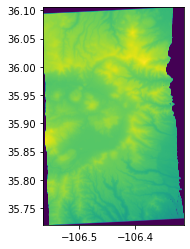

EPSG:4326


In [3]:
from rasterio.plot import show
import rasterio as rio
with rio.open('/Users/zachkeskinen/Documents/uavsar_snow/jemez_slc/geolocated_tiffs/llh.z.tif') as src:
    show(src)
    print(src.crs)